# Xsuite Tutorial

This notebook provides a hands‑on introduction to the [Xsuite](https://xsuite.readthedocs.io) accelerator‑physics toolkit. Each section introduces a key concept and accompanies it with a short, runnable example.

> **Prerequisites**
> ```bash
> pip install xsuite notebook ipympl xplt
> ```

## Introduction

In the following tutorial we will review transverse beam dynamic concepts 


In [1]:
# import useful libraries
import numpy as np  # arrays and math
import matplotlib.pyplot as plt  # plots
import xtrack as xt  # tracking module of Xsuite
#%matplotlib widget

## Ring design

In [2]:
# Reference energy
part = xt.Particles(mass0=xt.PROTON_MASS_EV, p0c=1e9)  # Mass eV/c^2 Momentum in eV/c

# Element geometry
env=xt.Environment()
env.vars.default_to_zero = True
env['pi']= np.pi
env['n_bends']= 16
env['ang_mb'] = '2*pi/n_bends'
env['l_mb'] = 1.2
env['l_mq'] = 0.4

#Dipoles
env.new('mb', xt.Bend, length='l_mb', angle='ang_mb', k0_from_h=True) # k0 scaled magnetic field k_0 = q/P B_y 
# Quadrupole families with different strengths
env.new('mq', xt.Quadrupole, length='l_mq')
env.new('qf', 'mq', k1='kqf') # Focusing quadrupole  k1>0
env.new('qd', 'mq', k1='kqd') # De-focusing quadrupole k1<0
#Markers
env.new("start_cell",xt.Marker)
env.new("end_cell",xt.Marker);

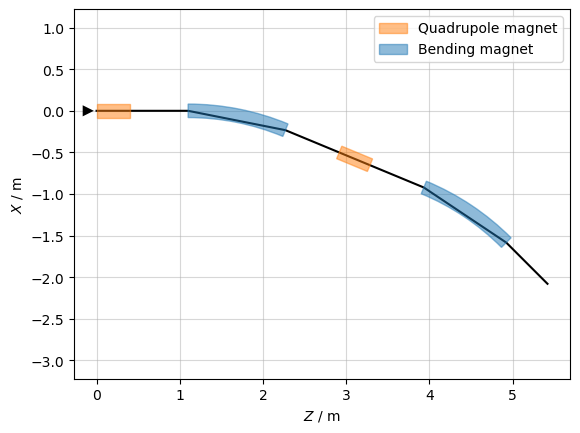

In [3]:
cell = env.new_line(
    length=6, # 6 m length
    components=[
    env.place('start_cell', at=0),
    env.place('qd', at=0.2),   # refer to the center by default
    env.place('mb', at=1.7),
    env.place('qf', at=3.2),
    env.place('mb', at=4.7),
    env.place('end_cell',at=6),
    ]
)
cell.survey().plot()

### Stability criterion based on eigenvalues

Definition of transfer matrix of a secion of a beam line
$$ \begin{pmatrix} x \\p_x \\y \\p_y \end{pmatrix}_\text{final}=
\begin{pmatrix}
r_{11}&r_{12}&r_{13}&r_{14} \\
r_{21}&r_{22}&r_{23}&r_{24} \\
r_{31}&r_{32}&r_{33}&r_{34} \\
r_{41}&r_{42}&r_{43}&r_{44} \\
\end{pmatrix}
\begin{pmatrix} x \\p_x \\y \\p_y \end{pmatrix}_\text{initial}
$$
if we call 
$$z=\begin{pmatrix}  x \\p_x \\y \\p_y \end{pmatrix} \qquad R=\begin{pmatrix}
r_{11}&r_{12}&r_{13}&r_{14} \\
r_{21}&r_{22}&r_{23}&r_{24} \\
r_{31}&r_{32}&r_{33}&r_{34} \\
r_{41}&r_{42}&r_{43}&r_{44} \\
\end{pmatrix}$$
we can write for a system made of $N$ repetition of the sevaral section 
$$ z_\text{final} = R \ldots R z_\text{initial} = R^N z_\text{initial} $$

With an eigenvalue decomposition we can write:
$$ R = A D A^{-1}\qquad \text{with} \qquad 
D=\begin{pmatrix}
\lambda_1&0&0&0 \\
0&\lambda_2&0&0 \\
0&0&\lambda_3&0 \\
0&0&0&\lambda_4 \\
\end{pmatrix}$$ then we can write

$$ z_\text{final} = R \ldots R z_\text{initial} =
A D A^{-1}  \ldots A D A^{-1} z_\text{initial} =
A D^N A^{-1} z_\text{initial}
$$ 
with
$$ D^N = \begin{pmatrix}
\lambda_1^N&0&0&0 \\
0&\lambda_2^N&0&0 \\
0&0&\lambda_3^N&0 \\
0&0&0&\lambda_4^N \\
\end{pmatrix}
$$
Conservative forces imply that $\lambda_1\lambda_2=1$ and $\lambda_3\lambda_4=1$. If all eigenvalues are complex, $|(\lambda_i^N)|=1$ for any $i$ and $N$ and therefore the motion is bounded. If there is one real eigenvalue, there is at least one real $\lambda_i>1$ for which $\lambda_i^N\gg1$.







In [4]:
cell.particle_ref=part

def get_eigenvalues(line):
    m=line.twiss4d(betx=1,bety=1).get_R_matrix(start='start_cell', end='end_cell')[:4,:4]
    eigv=np.linalg.eigvals(m)
    return eigv



env['kqf']=0.4; env['kqd']=-0.4
eig=get_eigenvalues(cell)
print("Eigenvalue       Real            Imag            Abs        Phase ")
for ii in range(4):
    print(f"lambda_{ii+1} {eig[ii].real:15.5f} {eig[ii].imag:15.5f} {np.abs(eig[ii]):15.5f}  {np.rad2deg(np.angle(eig[ii])):15.5f}")
    


Eigenvalue       Real            Imag            Abs        Phase 
lambda_1         0.22821         0.97361         1.00000         76.80831
lambda_2         0.22821        -0.97361         1.00000        -76.80831
lambda_3         0.89504         0.44598         1.00000         26.48588
lambda_4         0.89504        -0.44598         1.00000        -26.48588


In [5]:
def mkscan(line):
    out=[]
    k1v=np.linspace(0,2,51)
    for k1 in k1v:
        env['kqf']=k1;env['kqd']=-k1
        out.append(get_eigenvalues(line))
    return k1v,np.array(out)

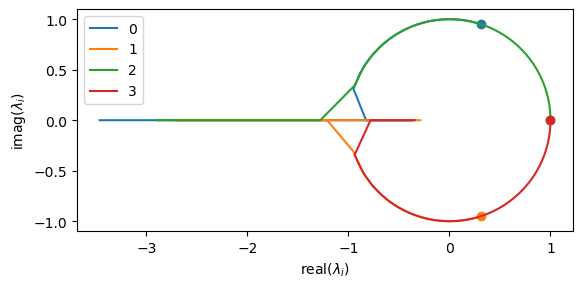

In [6]:
k1v,out=mkscan(cell)
fig,ax=plt.subplots()
ax.set_aspect('equal')
for ii in range(4):
  ax.plot(out[:,ii].real,out[:,ii].imag,label=f'{ii}')
  ax.plot([out[0,ii].real],[out[0,ii].imag],f'oC{ii}')
ax.legend()
ax.set_xlabel(r"real($\lambda_i$)")
ax.set_ylabel(r"imag($\lambda_i$)");

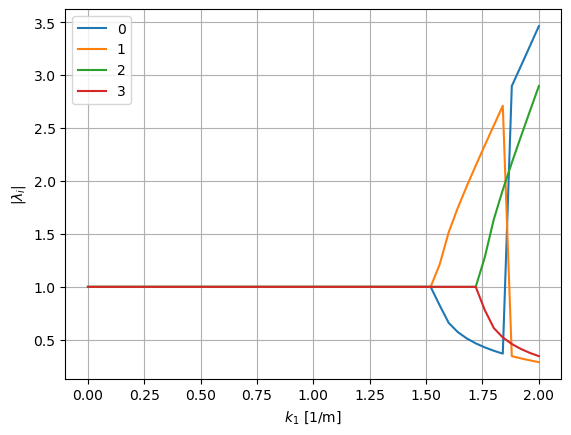

In [7]:
fig,ax=plt.subplots()
for ii in range(4):
  ax.plot(k1v,np.abs(out[:,ii]),label=f'{ii}')

ax.set_xlabel(r"$k_1$ [1/m]")
ax.set_ylabel(r"$|\lambda_i|$")
ax.grid(True)
ax.legend()

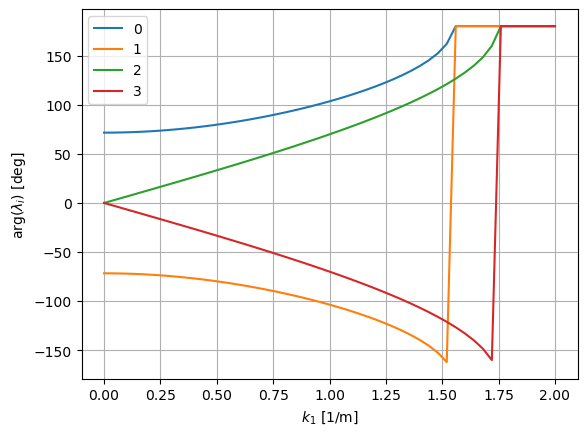

In [8]:
fig,ax=plt.subplots()
for ii in range(4):
  ax.plot(k1v,np.rad2deg(np.angle(out[:,ii])),label=f'{ii}')

ax.set_xlabel(r"$k_1$ [1/m]")
ax.set_ylabel(r"arg($\lambda_i$) [deg]")
ax.grid(True)
ax.legend()

## Ring and beta function

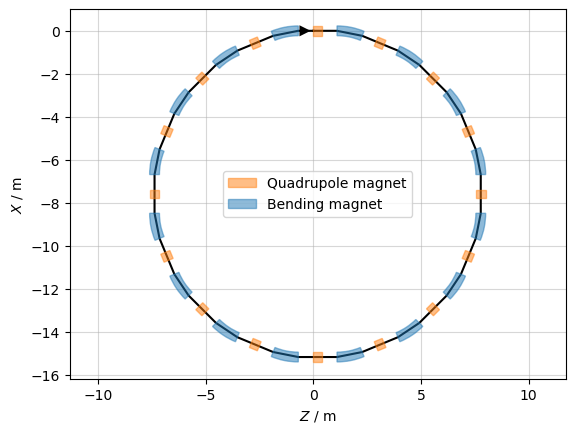

In [9]:
env['kqf']=0.8; env['kqd']=-0.8
ring=env['n_bends']//2*cell
ring.particle_ref=part
ring.survey().plot()

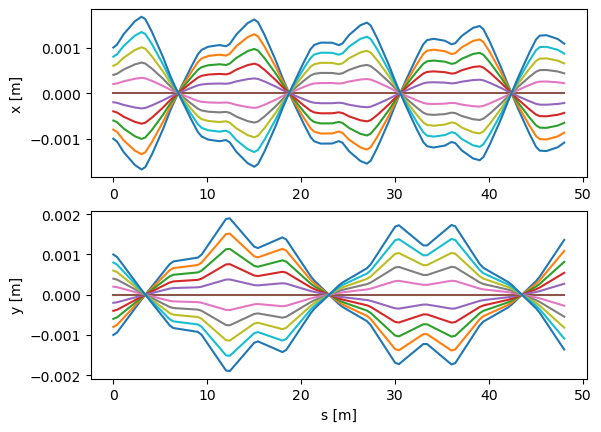

In [10]:
def track_and_plot(line, part):
    line.track(part.copy(), turn_by_turn_monitor="ONE_TURN_EBE")  # collect element by element data
    data=line.record_last_track
    fig,(ax1,ax2)=plt.subplots(2)
    ax1.plot(data.s.T, data.x.T, '-')
    ax2.plot(data.s.T, data.y.T, '-')
    ax2.set_xlabel('s [m]')
    ax1.set_ylabel('x [m]')
    ax2.set_ylabel('y [m]')
    return data
    
p0=ring.build_particles(x=np.linspace(-0.001,0.001,11),y=np.linspace(-0.001,0.001,11))

data=track_and_plot(ring,p0)

**xsuite follows a local reference frame**

$$ Q(s) = R_0(s) + x(s) \hat x(s) + y(s) \hat y(s)$$ 

(81, 2) (81, 2) (81,)


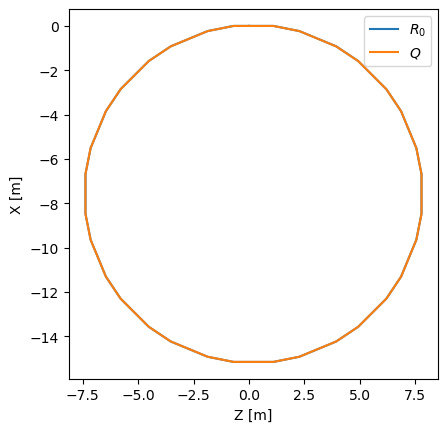

In [11]:
su=ring.survey()
R0=np.c_[su.X,su.Z] # X,Z components of R0
xh=np.c_[np.cos(su.theta),-np.sin(su.theta)] #xhat components
x=data.x[0].T
print(R0.shape,xh.shape,x.shape)
Q=R0+x[:,np.newaxis]*xh


fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(R0[:,1],R0[:,0],label=r"$R_0$")
ax.plot(Q[:,1],Q[:,0],label=r"$Q$")
ax.set_xlabel("Z [m]")
ax.set_ylabel("X [m]")
ax.legend()

(81, 2) (81, 2) (81,)


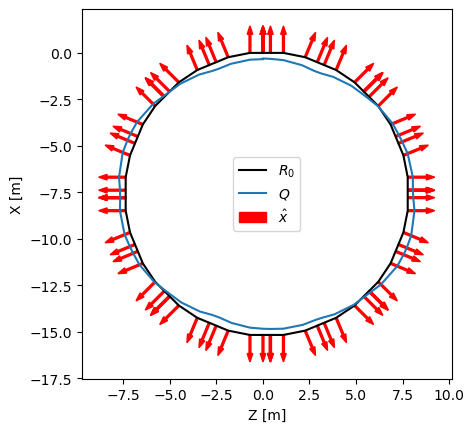

In [12]:
p0=ring.build_particles(x=np.linspace(-0.3,0.3,11))
ring.track(p0, turn_by_turn_monitor="ONE_TURN_EBE")
data=ring.record_last_track

su=ring.survey()
R0=np.c_[su.X,su.Z] # X(s),Z(s) components of R0(s)
xh=np.c_[np.cos(su.theta),-np.sin(su.theta)] #xhat(s) components
x=data.x[0].T # x(s) components
print(R0.shape,xh.shape,x.shape)
Q=R0+x[:,np.newaxis]*xh # numpy broadcasting!

fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(R0[:,1],R0[:,0],'k',label=r"$R_0$")
ax.plot(Q[:,1],Q[:,0],label=r"$Q$")
ax.set_xlabel("Z [m]")
ax.set_ylabel("X [m]")
ax.arrow(R0[0,1],R0[0,0],R0[0,1]+xh[0,1],xh[0,0],color='r',width=0.1,label=r'$\hat x$')
for ii in range(0,len(xh)):
   ax.arrow(R0[ii,1],R0[ii,0],xh[ii,1],xh[ii,0],color='r',width=0.1)
ax.legend()

(81, 2) (81, 2) (81, 11)


Text(0, 0.5, 'X [m]')

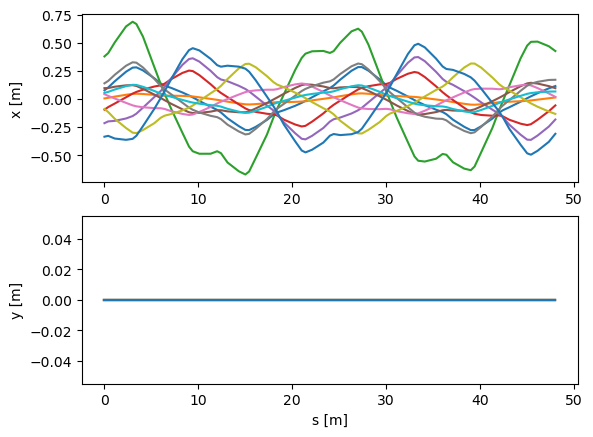

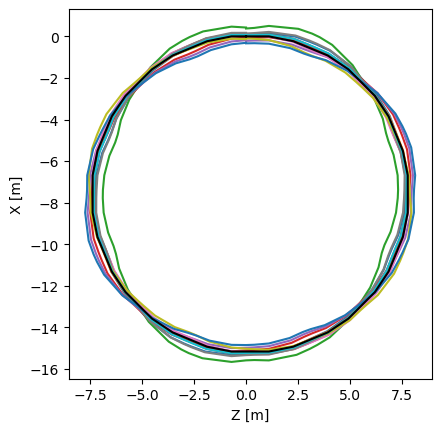

In [13]:
p0=ring.build_particles(x=0.8*(np.random.rand(11)-0.5),px=0.2*(np.random.rand(11)-0.5))
data=track_and_plot(ring,p0)

su=ring.survey()
R0=np.c_[su.X,su.Z] # X,Z components of R0
xh=np.c_[np.cos(su.theta),-np.sin(su.theta)] #xhat components
x=data.x.T
print(R0.shape,xh.shape,x.shape)
Q=R0[:,:,np.newaxis]+x[:,np.newaxis]*xh[:,:,np.newaxis] # numpy broadcasting!

fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(Q[:,1],Q[:,0],label=r"$Q$")
ax.plot(R0[:,1],R0[:,0],'k',label=r"$R_0$")
ax.set_xlabel("Z [m]")
ax.set_ylabel("X [m]")

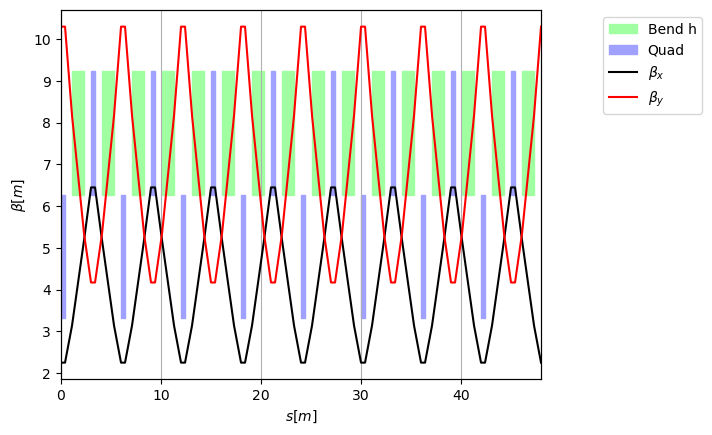

In [14]:
ring.twiss4d().plot('betx bety')

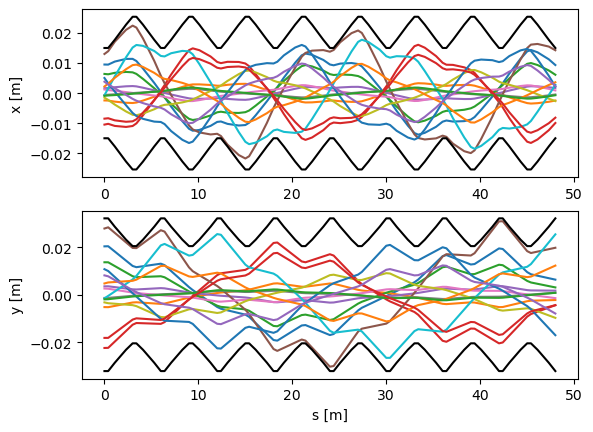

In [15]:
a=np.random.rand(15)*0.01
phi=np.random.rand(15)*2*np.pi
p0=ring.build_particles(
    x_norm=(a*np.cos(phi)),px_norm=(a*np.sin(phi)),
    y_norm=(a*np.cos(phi)),py_norm=(a*np.sin(phi))
    ,method='4d')

track_and_plot(ring,p0)
tw=ring.twiss4d()
fig=plt.gcf()
ax1,ax2=fig.get_axes()
ax1.plot(tw.s,0.01*np.sqrt(tw.betx),'k')
ax1.plot(tw.s,-0.01*np.sqrt(tw.betx),'k')
ax2.plot(tw.s,0.01*np.sqrt(tw.bety),'k')
ax2.plot(tw.s,-0.01*np.sqrt(tw.bety),'k')

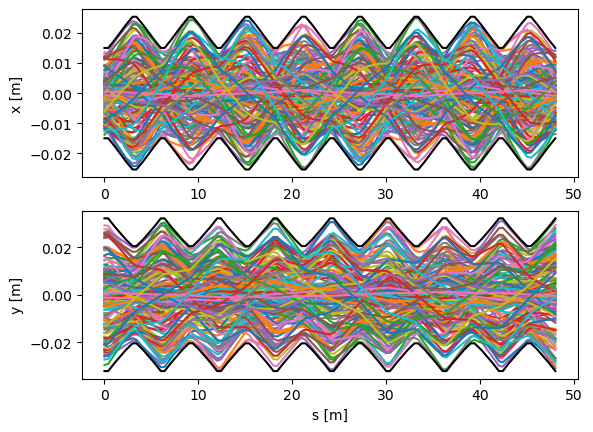

In [16]:
a=np.random.rand(151)*0.01
phi=np.random.rand(151)*2*np.pi
p0=ring.build_particles(
    x_norm=(a*np.cos(phi)),px_norm=(a*np.sin(phi)),
    y_norm=(a*np.cos(phi)),py_norm=(a*np.sin(phi))
    ,method='4d')

track_and_plot(ring,p0)
tw=ring.twiss4d()
fig=plt.gcf()
ax1,ax2=fig.get_axes()
ax1.plot(tw.s,0.01*np.sqrt(tw.betx),'k')
ax1.plot(tw.s,-0.01*np.sqrt(tw.betx),'k')
ax2.plot(tw.s,0.01*np.sqrt(tw.bety),'k')
ax2.plot(tw.s,-0.01*np.sqrt(tw.bety),'k')

Qx=0.2556, Qy=0.1515  max(betx)=6.4490 max(bety)=10.2987


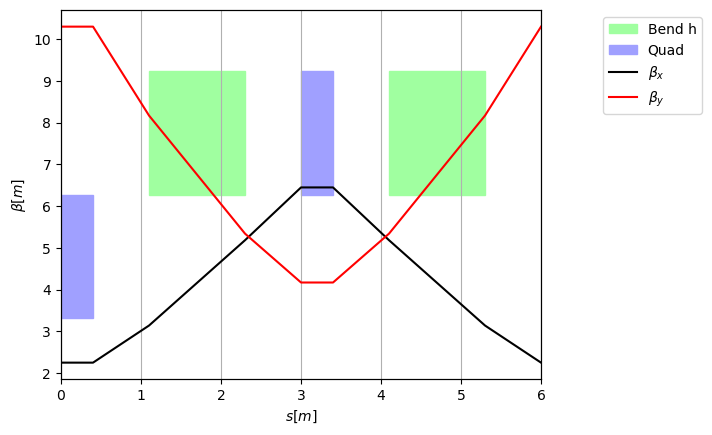

In [17]:
env['kqf']=0.8; env['kqd']=-0.8
tw=cell.twiss4d()
tw.plot('betx bety')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

Qx=0.2214, Qy=0.0924  max(betx)=5.8077 max(bety)=13.7010


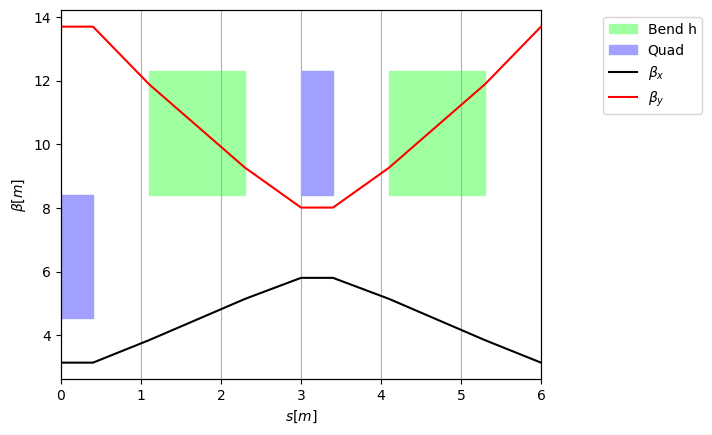

In [18]:
env['kqf']=0.5; env['kqd']=-0.5
tw=cell.twiss4d()
tw.plot('betx bety')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

Qx=0.2214, Qy=0.0924  max(betx)=5.8077 max(bety)=13.7010


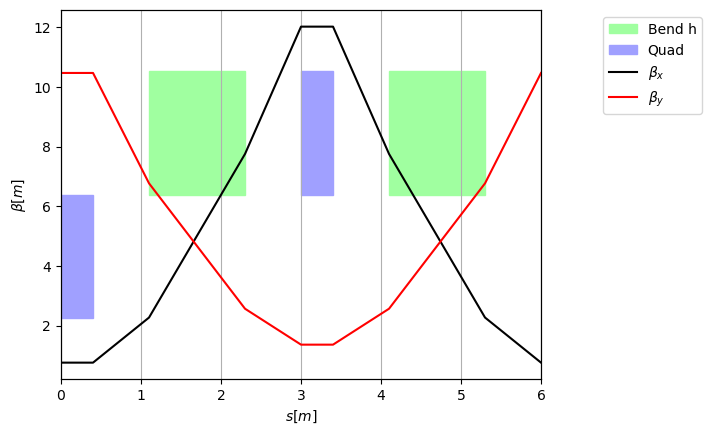

In [19]:
env['kqf']=1.4; env['kqd']=-1.4
cell.twiss4d().plot('betx bety')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

In [20]:
mtc=cell.match(method='4d',
    vary=xt.VaryList(['kqf','kqd']),
    targets=[xt.Target(tar='betx',at='qf',value=10),
            xt.Target(tar='bety',at='qd',value=10)]
)
print(f"kqf={env['kqf']:.4f}, kqd={env['kqd']:.4f}")

                                             
Optimize - start penalty: 2.073                             
Matching: model call n. 41 penalty = 1.3634e-10              
Optimize - end penalty:  1.36342e-10                            
kqf=1.3191, kqd=-1.3486


kqf=1.3191, kqd=-1.3486
Qx=0.3593, Qy=0.2822  max(betx)=10.0000 max(bety)=10.0000


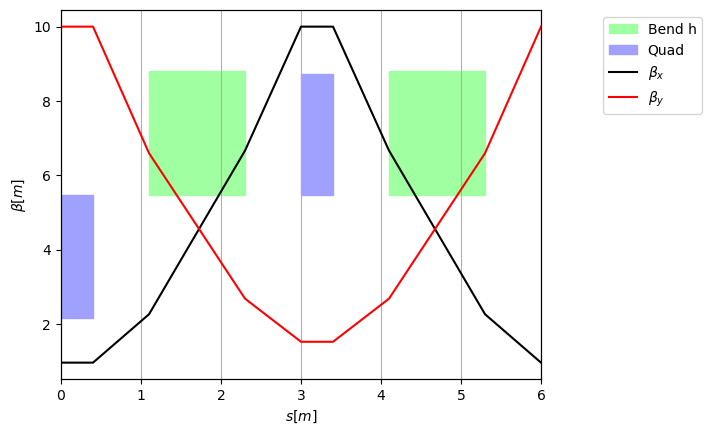

In [21]:
print(f"kqf={env['kqf']:.4f}, kqd={env['kqd']:.4f}")
tw=cell.twiss4d()
tw.plot('betx bety')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

Qx=2.8745, Qx=2.2577


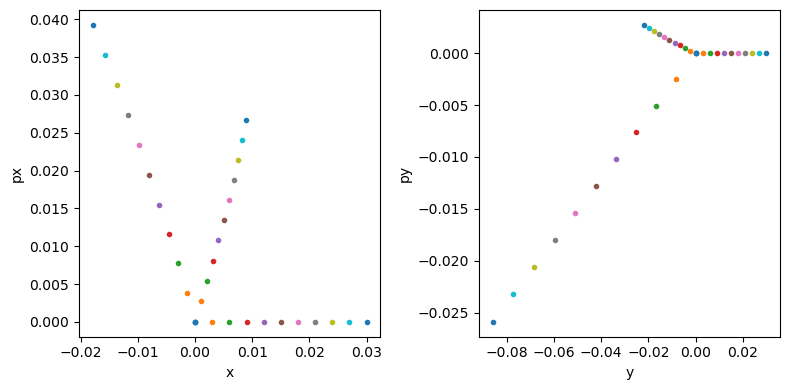

In [22]:
p0=ring.build_particles(x=np.linspace(0,0.03,11), y=np.linspace(0,0.03,11))
ring.track(p0,num_turns=3,turn_by_turn_monitor=True)
data=ring.record_last_track
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
ax1.plot(data.x.T,data.px.T,'.')
ax2.plot(data.y.T,data.py.T,'.')
ax1.set_xlabel("x"); ax1.set_ylabel("px")
ax2.set_xlabel("y"); ax2.set_ylabel("py")
fig.tight_layout()
tw=ring.twiss4d()
print(f"Qx={tw.qx:5.4f}, Qx={tw.qy:5.4f}") 

In [23]:
0.8745*8

6.996

Qx=2.8745, Qy=2.2577


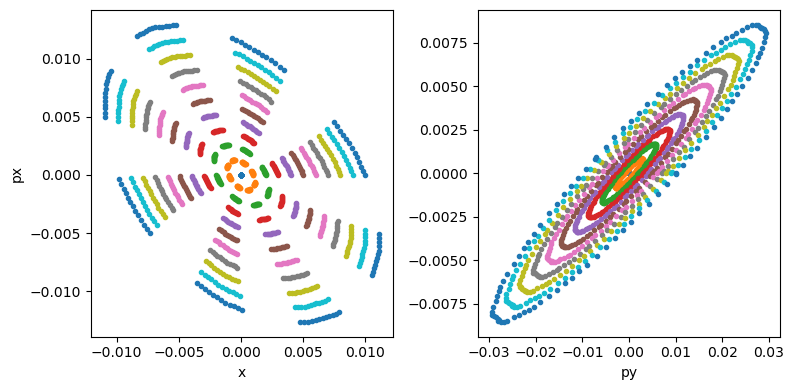

In [24]:
p0=ring.build_particles(x=np.linspace(0,0.01,11), y=np.linspace(0,0.01,11))
ring.track(p0,num_turns=101,turn_by_turn_monitor=True)
data=ring.record_last_track
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
ax1.plot(data.x.T,data.px.T,'.')
ax2.plot(data.y.T,data.py.T,'.')
ax1.set_xlabel("x"); ax1.set_ylabel("px")
ax2.set_xlabel("y"); ax2.set_xlabel("py")
fig.tight_layout()
tw=ring.twiss4d()
print(f"Qx={tw.qx:5.4f}, Qy={tw.qy:5.4f}") 

Text(0.5, 0, 'Turns')

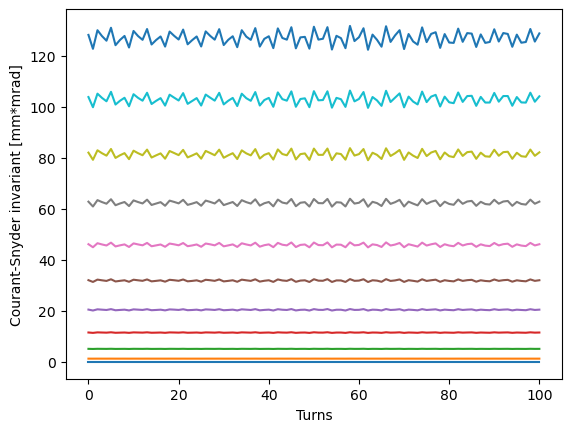

In [25]:
x,px=data.x,data.px;
betx=tw.betx[0,np.newaxis];alfx=tw.alfx[0,np.newaxis]; gammax=(1+alfx**2)/betx
fig,ax=plt.subplots()
I=gammax*x**2+2*alfx*x*px+betx*px**2
ax.plot(I.T*1e6)
ax.set_ylabel("Courant-Snyder invariant [mm*mrad]")
ax.set_xlabel("Turns")

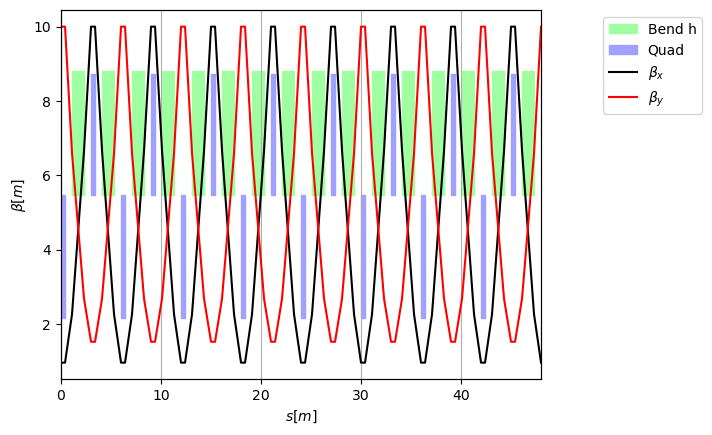

In [26]:
ring.twiss4d().plot('betx bety')

## Ring and dispersion

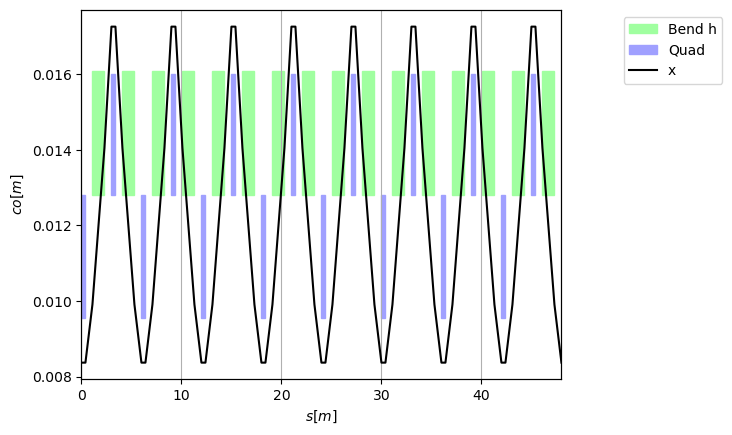

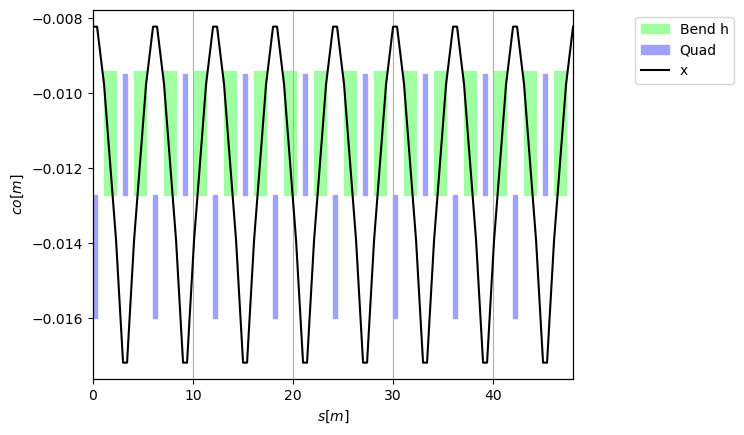

In [27]:
ring.twiss4d(delta0=0.01).plot('x')
ring.twiss4d(delta0=-0.01).plot('x')

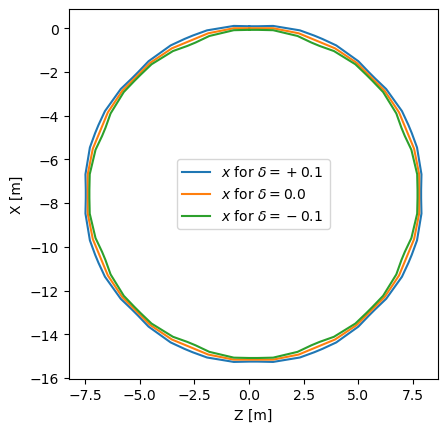

In [28]:
twp=ring.twiss4d(delta0=+0.1)
tw0=ring.twiss4d(delta0=0.00)
twm=ring.twiss4d(delta0=-0.1)

su=ring.survey()
R0=np.c_[su.X,su.Z] # X,Z components of R0
xh=np.c_[np.cos(su.theta),-np.sin(su.theta)] #xhat components
Qp=R0+twp.x[:,np.newaxis]*xh
Q0=R0+tw0.x[:,np.newaxis]*xh
Qm=R0+twm.x[:,np.newaxis]*xh

fig,ax=plt.subplots()
ax.set_aspect('equal')
ax.plot(Qp[:,1],Qp[:,0],label=r"$x$ for $\delta=+0.1$ ")
ax.plot(Q0[:,1],Q0[:,0],label=r"$x$ for $\delta=0.0$")
ax.plot(Qm[:,1],Qm[:,0],label=r"$x$ for $\delta=-0.1$")
ax.set_xlabel("Z [m]")
ax.set_ylabel("X [m]")
ax.legend()

All particles are tracked to a given $s$, which means some particles will arrive earlier and some later.

The arrival time is available in the coordinate $\zeta=s-\beta_0 ct$.

The energy deviation is avaible in $p_\zeta=\frac{E-E_0}{\beta_0 P_0 c}$ or the more conventional variable $\delta=\frac{P-P_0}{P_0}$

In [29]:
p0=ring.build_particles(delta=[-0.01,0,0.01])
p0.reset_s_at_end_turn=False
ring.track(p0)
clight=299792458 #m/s
t=(p0.s/p0.beta0 - p0.zeta)/clight
for ii in range(len(t)):
    print(f"Particle {ii}: zeta={p0.zeta[ii]:6.3f} m or time={t[ii]*1e9:6.3f} ns")

Particle 0: zeta=-0.151 m or time= 0.503 ns
Particle 1: zeta=-0.000 m or time= 0.000 ns
Particle 2: zeta= 0.141 m or time=-0.472 ns


In [30]:
p0=ring.build_particles(delta=[-0.01,0,0.01])
l_ring=su.s[-1]
ring.track(p0,num_turns=1000)
t=(p0.at_turn*l_ring/p0.beta0 - p0.zeta)/clight
for ii in range(len(t)):
    print(f"Particle {ii}: zeta={p0.zeta[ii]:9.3f} m or time={t[ii]*1e3:9.3f} ms")

Particle 0: zeta= -155.287 m or time=    0.220 ms
Particle 1: zeta=   -0.000 m or time=    0.220 ms
Particle 2: zeta=  147.625 m or time=    0.219 ms


Text(0, 0.5, 'zeta [m]')

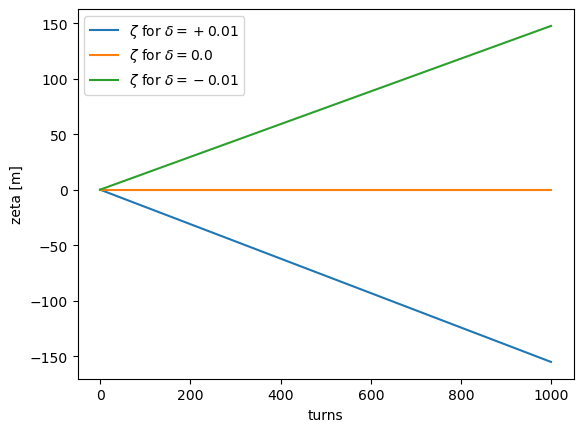

In [31]:
p0=ring.build_particles(delta=[-0.01,0,0.01])
ring.track(p0,num_turns=1000,turn_by_turn_monitor=True)
data=ring.record_last_track
fig,ax=plt.subplots()
ax.plot(data.zeta[0],label=r"$\zeta$ for $\delta=+0.01$")
ax.plot(data.zeta[1],label=r"$\zeta$ for $\delta=0.0$")
ax.plot(data.zeta[2],label=r"$\zeta$ for $\delta=-0.01$")
ax.legend()
ax.set_xlabel('turns')
ax.set_ylabel('zeta [m]')

In [32]:
ring2=ring.copy(shallow=True)
period=l_ring/clight/part.beta0[0]
if 'cav' not in env.element_dict:
    env.new("cav",xt.Cavity,voltage='voltage',frequency=1/period)
ring2.insert('cav',at=0)
env['voltage']=0.1e6 #V
ring2.particle_ref=part
print(env['cav'].voltage, env['cav'].frequency)

Slicing line:   0%|          | 0/80 [00:00<?, ?it/s]

100000.0 4554698.115884685


Text(0, 0.5, 'zeta [m]')

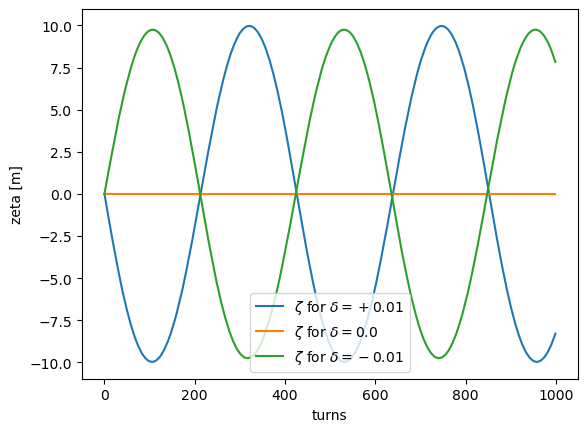

In [33]:
p0=ring2.build_particles(delta=[-0.01,0,0.01])
ring2.track(p0,num_turns=1000,turn_by_turn_monitor=True)
data=ring2.record_last_track
fig,ax=plt.subplots()
ax.plot(data.zeta[0],label=r"$\zeta$ for $\delta=+0.01$")
ax.plot(data.zeta[1],label=r"$\zeta$ for $\delta=0.0$")
ax.plot(data.zeta[2],label=r"$\zeta$ for $\delta=-0.01$")
ax.legend()
ax.set_xlabel('turns')
ax.set_ylabel('zeta [m]')

Text(0, 0.5, 'delta')

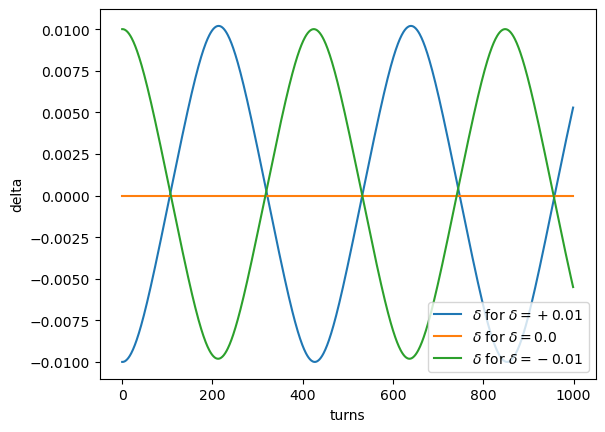

In [34]:
fig,ax=plt.subplots()
ax.plot(data.delta[0],label=r"$\delta$ for $\delta=+0.01$")
ax.plot(data.delta[1],label=r"$\delta$ for $\delta=0.0$")
ax.plot(data.delta[2],label=r"$\delta$ for $\delta=-0.01$")
ax.legend()
ax.set_xlabel('turns')
ax.set_ylabel('delta')

Text(0, 0.5, 'delta')

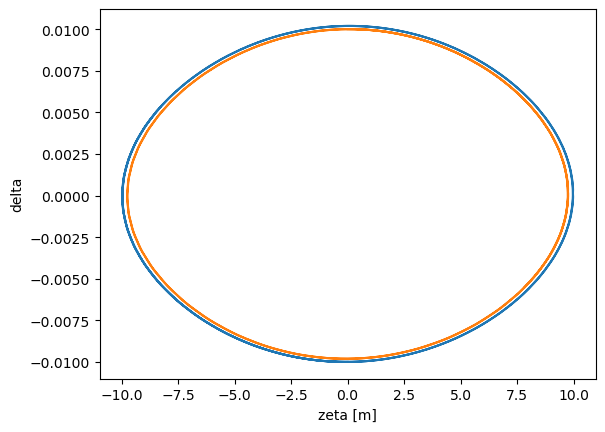

In [35]:
p0=ring2.build_particles(delta=[-0.01,0.01])
ring2.track(p0,num_turns=1000,turn_by_turn_monitor=True)
data=ring2.record_last_track
fig,ax=plt.subplots()
ax.plot(data.zeta.T,data.delta.T)
ax.set_xlabel(r'zeta [m]')
ax.set_ylabel(r'delta')

Text(0, 0.5, 'delta')

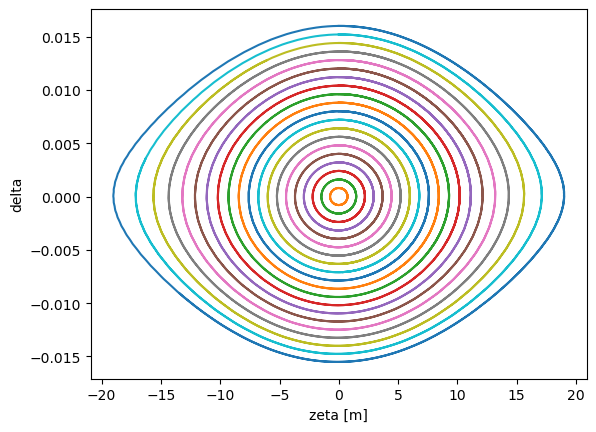

In [36]:
p0=ring2.build_particles(delta=np.linspace(0,0.016,21))
ring2.track(p0,num_turns=1000,turn_by_turn_monitor=True)
data=ring2.record_last_track
fig,ax=plt.subplots()
ax.plot(data.zeta.T,data.delta.T)
ax.set_xlabel(r'zeta [m]')
ax.set_ylabel(r'delta')

Text(0, 0.5, 'delta')

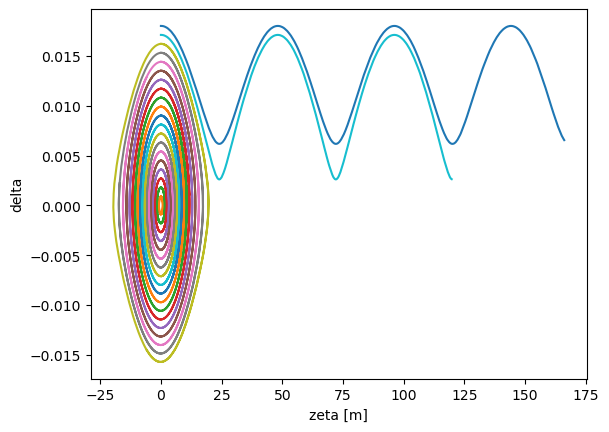

In [37]:
p0=ring2.build_particles(delta=np.linspace(0,0.018,21))
ring2.track(p0,num_turns=1000,turn_by_turn_monitor=True)
data=ring2.record_last_track
fig,ax=plt.subplots()
ax.plot(data.zeta.T,data.delta.T)
ax.set_xlabel(r'zeta [m]')
ax.set_ylabel(r'delta')

## Racetrack

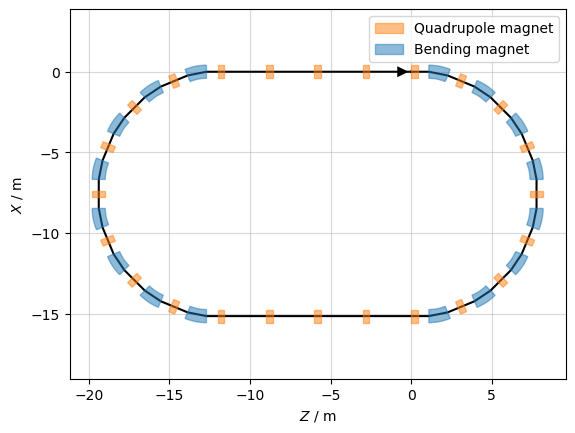

In [38]:
if "qd2" not in env.element_dict:
    env.new('qf2', 'mq', k1='kqf2')
    env.new('qd2', 'mq', k1='kqd2')

cell_s = env.new_line(
    length=6,
    components=[
    env.place('qd2', at=0.2),    
    env.place('qf2', at=3.2),
    ]
)

env['kqf2']=env['kqf']+env['mb'].h**2
env['kqd2']=env['kqd']

cell_s.particle_ref=part
ring3=env['n_bends']//4*cell+2*cell_s+env['n_bends']//4*cell+2*cell_s
ring3.particle_ref=part
ring3.survey().plot()

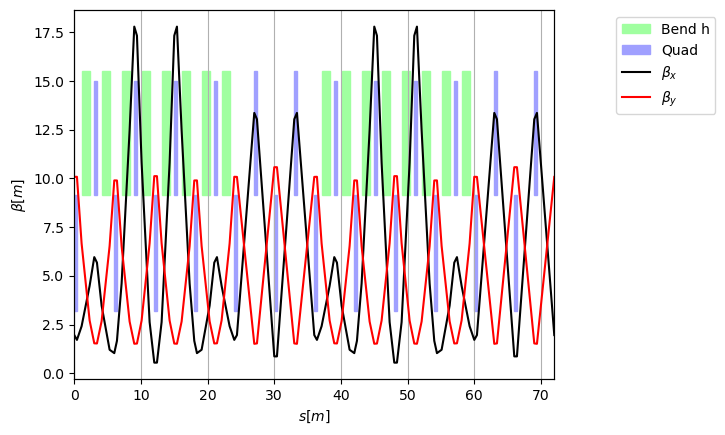

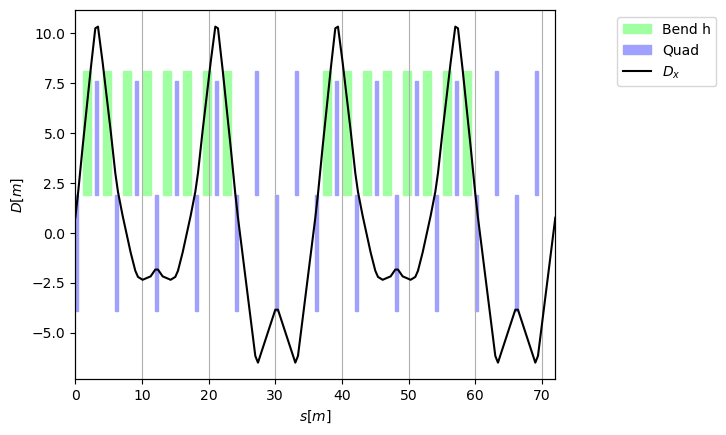

In [39]:
ring3.twiss4d().plot('betx bety')
ring3.twiss4d().plot('dx')

                                             
Optimize - start penalty: 1.14                              
Matching: model call n. 37 penalty = 2.6699e-09              
Optimize - end penalty:  2.66988e-09                            
kqf=0.8817, kqd=-1.1615
Qx=0.2500, Qy=0.2500  max(betx)=7.4570 max(bety)=8.4301


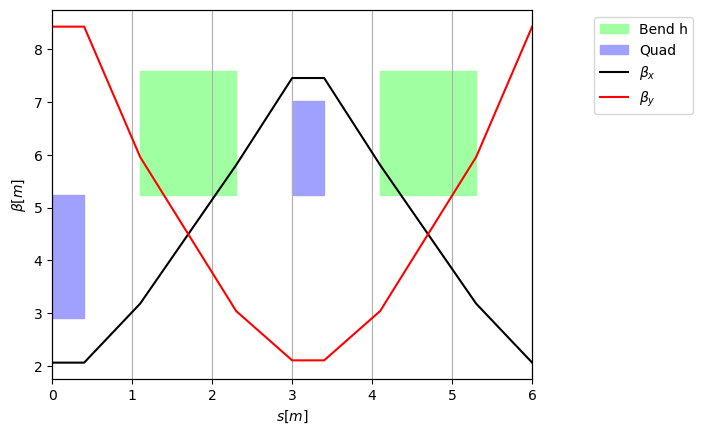

In [40]:
mtc=cell.match(method='4d',
    vary=xt.VaryList(['kqf','kqd']),
    targets=[xt.Target(tar='mux',at='end_cell',value=1/4),
            xt.Target(tar='muy',at='end_cell',value=1/4)]
)

print(f"kqf={env['kqf']:.4f}, kqd={env['kqd']:.4f}")
tw=cell.twiss4d()
tw.plot('betx bety')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

Qx=3.2286, Qy=3.1090  max(betx)=10.5062 max(bety)=10.6290


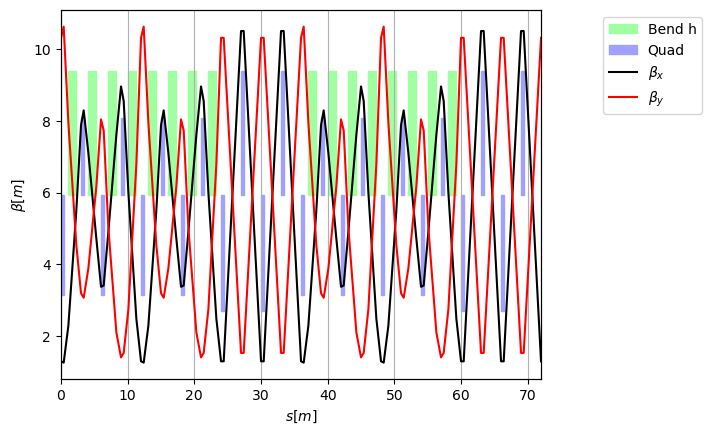

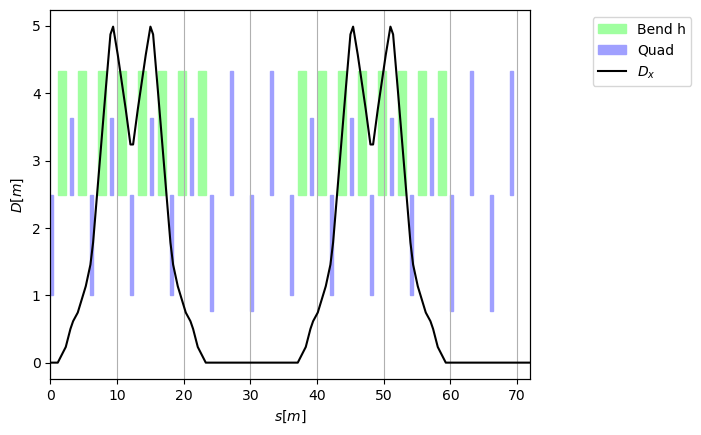

In [41]:
tw=ring3.twiss4d()
tw.plot('betx bety')
tw.plot('dx')
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

                                             
Optimize - start penalty: 4.367                             
Matching: model call n. 29 penalty = 5.7073e-09              
Optimize - end penalty:  5.70728e-09                            
kqf=0.8817, kqd=-1.1615
Qx=3.3100, Qy=2.6800  max(betx)=9.9500 max(bety)=11.9889


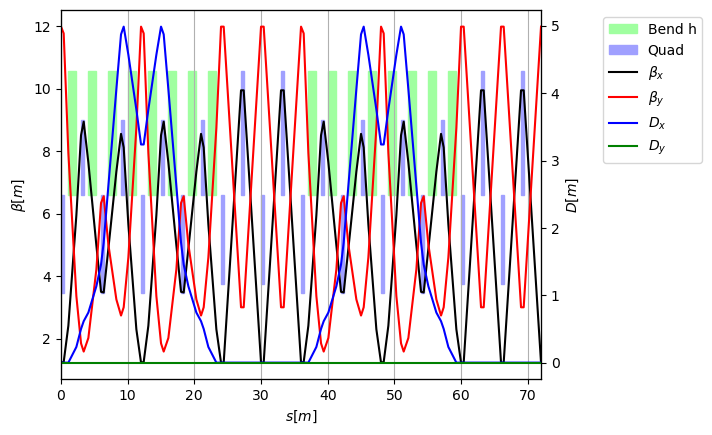

In [42]:
mtc=ring3.match(method='4d',
    vary=xt.VaryList(['kqf2','kqd2']),
    targets=[xt.Target(tar='mux',at=xt.END,value=3.31),
            xt.Target(tar='muy',at=xt.END,value=2.68)]
)
tw=ring3.twiss4d()
tw.plot()
print(f"kqf={env['kqf']:.4f}, kqd={env['kqd']:.4f}")
print(f"Qx={tw.qx:.4f}, Qy={tw.qy:.4f}  max(betx)={np.max(tw.betx):.4f} max(bety)={np.max(tw.bety):.4f}")

## Chromaticity

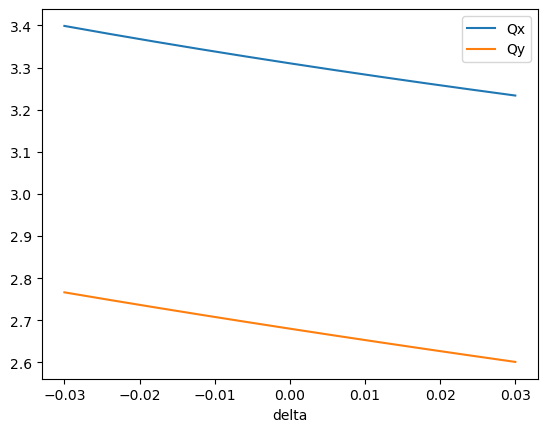

In [43]:
delta=np.linspace(-0.03,0.03,11)

qx=[ring3.twiss4d(delta0=dd).qx for dd in delta]
qy=[ring3.twiss4d(delta0=dd).qy for dd in delta]

fig,ax=plt.subplots()
ax.plot(delta,qx,label='Qx')
ax.plot(delta,qy,label='Qy')
ax.set_xlabel('delta')
ax.legend()

In [44]:
ring3.twiss4d().rows['qf.*'].cols['name s betx bety dx']
ring3.twiss4d().rows['qd.*'].cols['name s betx bety dx']

TwissTable: 12 rows, 5 cols
name               s          betx          bety            dx
qd::0              0       1.22796       11.9889   1.04006e-09
qd::1              6       3.49676       6.34057       1.45578
qd::2             12       1.22796       11.9889       3.23836
qd::3             18       3.49676       6.34057       1.78258
qd2::0            24       1.22796       11.9889   2.51107e-09
qd2::1            30       1.22796       11.9889   -3.8129e-09
qd::4             36       1.22796       11.9889  -6.61284e-11
qd::5             42       3.49676       6.34057       1.45578
qd::6             48       1.22796       11.9889       3.23836
qd::7             54       3.49676       6.34057       1.78258
qd2::2            60       1.22796       11.9889   6.95132e-10
qd2::3            66       1.22796       11.9889  -1.01218e-09

Slicing line:   0%|          | 0/96 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/98 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/100 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/104 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/106 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/108 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/110 [00:00<?, ?it/s]

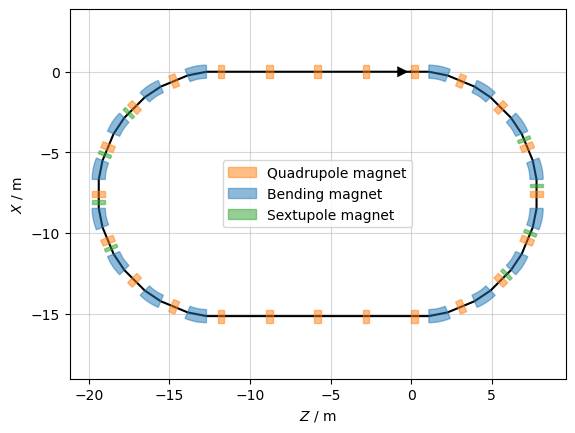

In [45]:
if "msf" not in env.element_dict:
    env.new('ms', xt.Sextupole, length=0.2)
    env.new('msf', 'ms', k2='ksf')
    env.new('msd', 'ms', k2='ksd')

ring4=ring3.copy(shallow=True)
ring4.insert('msf',at=9-0.3)
ring4.insert('msf',at=15-0.3)
ring4.insert('msf',at=45-0.3)
ring4.insert('msf',at=51-0.3)
ring4.insert('msd',at=12-0.3)
ring4.insert('msd',at=18-0.3)
ring4.insert('msd',at=48-0.3)
ring4.insert('msd',at=54-0.3)

ring4.survey().plot()

In [46]:
[ring4.twiss4d().dqx,ring4.twiss4d().dqy] # chromaticy

[-2.733762116053917, -2.741608561112052]

In [47]:
opt_chrome = ring4.match(
    method='4d',
    vary=[
        xt.Vary('ksf', limits=(-3, 3),  step=1e-3),
        xt.Vary('ksd', limits=(-3, 3),  step=1e-3),
    ],
    targets=[
        xt.TargetSet(dqx=0, dqy=0, tol=1e-6),
    ]
)

                                             
Optimize - start penalty: 3.872                             
Matching: model call n. 9 penalty = 5.1020e-07              
Optimize - end penalty:  5.10196e-07                            


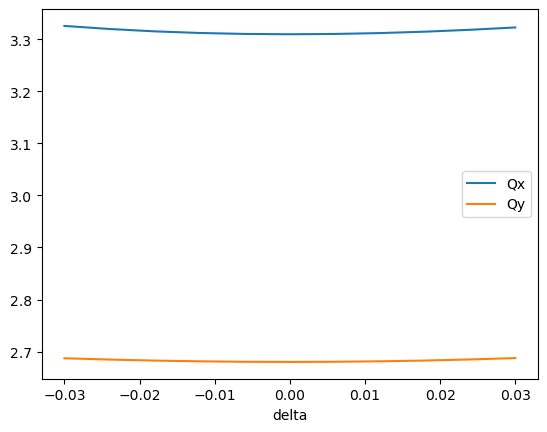

In [48]:
delta=np.linspace(-0.03,0.03,11)

qx=[ring4.twiss4d(delta0=dd).qx for dd in delta]
qy=[ring4.twiss4d(delta0=dd).qy for dd in delta]

fig,ax=plt.subplots()
ax.plot(delta,qx,label='Qx')
ax.plot(delta,qy,label='Qy')
ax.set_xlabel('delta')
ax.legend()

Qx=2.0000, Qx=2.0000


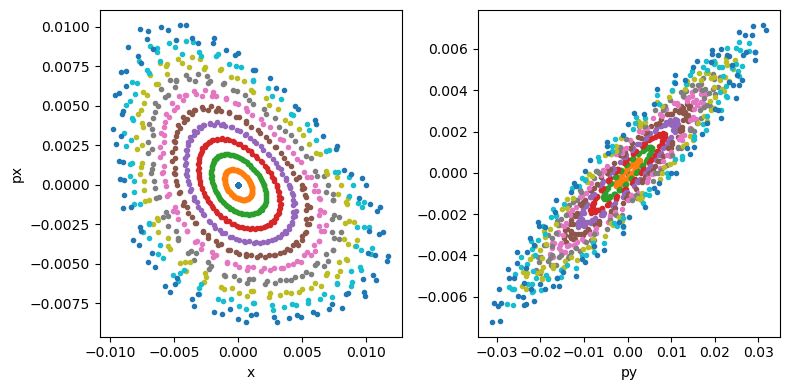

In [49]:
p0=ring4.build_particles(x=np.linspace(0,0.01,11), y=np.linspace(0,0.01,11))
ring4.track(p0,num_turns=101,turn_by_turn_monitor=True)
data=ring4.record_last_track
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
ax1.plot(data.x.T,data.px.T,'.')
ax2.plot(data.y.T,data.py.T,'.')
ax1.set_xlabel("x"); ax1.set_ylabel("px")
ax2.set_xlabel("y"); ax2.set_xlabel("py")
fig.tight_layout()
tw=ring.twiss4d()
print(f"Qx={tw.qx:5.4f}, Qx={tw.qy:5.4f}") 

## Excercises

1. optimize the cost of the ring
   - specs
     - The ring is for 500 MeV protons.
     - There must be at least 2 straight sections with a drift of 2 m
     - Those straight sections should have 0 dispersion
     - Distance between magnets > 20 cm
     - Transverse emittance $\epsilon= 3$ mm mrad
     - Momentum spread $\delta_{\rm rms}$=1%.
     - Total fractional part of the tune 0.31 or 0.69, 0.32 or 0.68
   - costs
     - surface: 20 kEUR m^2
     - magnets: field <1.2T, e.g. for quadrupoles $|dBy/dx| \max(Ax,Ay) < 1.2T$
     - magnets: cost 50 kEUR/m
     - power converters 10 kEUR each

Aperture can be computed with:
- $A_x= 5\sqrt{\epsilon  \beta_x} + 4\delta_{\rm rms}D_x$
- $A_y= 5\sqrt{\epsilon  \beta_y} + 4\delta_{\rm rms}D_y$

## References

- [Xsuite manual](https://xsuite.readthedocs.io/en/latest/)
- [Xtrack source code](https://github.com/xsuite/xtrack/)
- [Python examples](https://github.com/xsuite/xtrack/tree/main/examples)

Notebook tutorials:
- [PIMMS medical syncrhotron](https://github.com/xsuite/tutorial_cern_seminar)



